# WeRateDogs Tweeter Archive

## Gather

In [1]:
import pandas as pd
import numpy as np
import requests
#import tweepy

In [2]:
tweet = pd.read_csv('twitter-archive-enhanced.csv')

In [ ]:
###
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
if r.status_code == 200:
    with open('image_predictions.tsv', 'wb') as f:
        f.write(r.content)

In [3]:
image = pd.read_csv('image_predictions.tsv', sep = '\t')

In [ ]:
###
consumer_key = 'X4Mu5bFyMBpjjstVS4XbYjZcL'
consumer_secret = '6nXJBPj6kBPzT0zP45fZnjiAOuMTN5OEBS3tQ7xKbfIT4NuIst'
access_token = '4366384514-l6MKA0qiPnv018rq4aSQPQd5TODG6Ko4gNeBlSA'
access_secret = '6HcJzhQoY9fZaTfj8p5XXyBdCjNsKiB8SUURkRmSQEh3H'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True )

In [ ]:
###
from timeit import default_timer as timer

start = timer()
tweet_id = []
retweet_count = []
favorite_count = []

for ids in image.tweet_id:
    try:
        tweet = api.get_status(ids, tweet_mode='extended')
        tweet_id.append(ids)
        retweet_count.append(tweet.retweet_count)
        favorite_count.append(tweet.favorite_count)
    except Exception as e:
        print(str(e))
        
end = timer()
print(end - start)    

In [ ]:
###
file = open("tweet_json.txt", "w")
for index in range(len(tweet_id)):
    file.write(str(tweet_id[index]) + " " + str(retweet_count[index]) + " " + str(favorite_count[index]) + "\n")
file.close()

In [4]:
info = pd.read_csv('tweet_json.txt', sep=" ", header=None)
info.columns = ['tweet_id','retweet_count','favorite_count']

## Assess

In [ ]:
tweet.head(10)

In [ ]:
image.head(10)

In [ ]:
info.head(10)

In [ ]:
tweet.info()

In [ ]:
image.info()

In [ ]:
info.info()

In [ ]:
all_columns = pd.Series(list(tweet) + list(image) + list(info))
all_columns[all_columns.duplicated()]

In [ ]:
list(tweet)

In [ ]:
list(image)

In [ ]:
tweet[tweet['expanded_urls'].isnull()]

In [ ]:
tweet.describe()

In [ ]:
image.describe()

In [ ]:
info.describe()

In [ ]:
tweet.sample(5)

In [ ]:
tweet.name.value_counts()

In [ ]:
tweet.source.value_counts()

In [ ]:
image.jpg_url.value_counts()

In [ ]:
tweet[tweet.name.duplicated()]

In [ ]:
tweet.rating_numerator.sort_values()

In [ ]:
tweet.rating_denominator.sort_values()

In [ ]:
len(tweet[(tweet['doggo'] == 'doggo')]) + len(tweet[(tweet['floofer'] == 'floofer')])  + len(tweet[(tweet['pupper'] == 'pupper')]) 
+ len(tweet[(tweet['puppo'] == 'puppo')]) 

#### Quality
##### `tweet` table
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id are int not float
- Erroneous datatypes (retweeted_status_timestamp, timestamp, text, and source columns) 
- source has four categories
- name sometimes lower case, captial letter other times
- Missing expanded_urls (2297 instead of 2356)
- Missing in_reply_to_status_id and in_reply_to_user_id (78 instead of 2356)
- Missing retweeted_status_id, retweeted_status_id, retweeted_status_id (181 instead of 2356)
- actually, by, his, my, one, the, very are not dog name
- Multiple records for 'a, an' as a name
- Some rating_numerator and rating_denominator are extremely high
- Some rows have rating_numerator and rating_denominator but do not have expanded_urls

##### `image` table
- Duplicates in jpg_url
- Lowercase p1, p2, p3
- Missing records (2075 instead of 2356)

##### `info` table
- Missing records (2069 instead of 2075)

#### Tidiness
- Merge doggo, pupper, puppo, and floofer columns into one column in `tweet` table
- `info` table and `image` table should be part of the `tweet` table

## Clean

In [5]:
tweet_clean = tweet.copy()
image_clean = image.copy()
info_clean = info.copy()

### Missing Data

#### `tweet`: Missing expanded_urls (2297 instead of 2356), Missing in_reply_to_status_id and in_reply_to_user_id (78 instead of 2356), Missing retweeted_status_id, retweeted_status_id, retweeted_status_id (181 instead of 2356)

##### Define
- Remove tweets that don't have image url
- Remove replied tweets
- Remove retweets

##### Code

In [6]:
tweet_clean = tweet_clean[~tweet_clean.expanded_urls.isnull()]

##### Test

In [ ]:
tweet_clean.head()

##### Code

In [7]:
tweet_clean = tweet_clean[tweet_clean['in_reply_to_status_id'].isnull()]

##### Test

In [ ]:
len(tweet_clean)

##### Code

In [8]:
tweet_clean = tweet_clean[tweet_clean['retweeted_status_id'].isnull()]

##### Test

In [ ]:
len(tweet_clean)

##### Code

In [9]:
drop_columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                'retweeted_status_user_id', 'retweeted_status_timestamp']

tweet_clean = tweet_clean.drop(labels = drop_columns, axis = 1)

##### Test

In [ ]:
tweet_clean.head()

### Quality

#### `tweet`: Erroneous datatypes (tweet_id, timestamp, text, and source columns) , Source has four categories

##### Define
- Change tweet_id to int data type
- Change timestamp to date data type
- Change text to string data type
- Change source to category data type
- Replace the four category source with short version

##### Code

In [10]:
tweet_clean.tweet_id = tweet_clean.tweet_id.astype(int) 
tweet_clean.text = tweet_clean.text.astype(str)
tweet_clean.source = tweet_clean.source.astype('category')
tweet_clean.timestamp = pd.to_datetime(tweet_clean.timestamp)

In [11]:
tweet_clean.source = tweet_clean.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
tweet_clean.source = tweet_clean.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine Make a Scene')
tweet_clean.source = tweet_clean.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
tweet_clean.source = tweet_clean.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'Tweet Deck')

##### Test

In [ ]:
tweet_clean.info()

In [ ]:
tweet_clean.head()

#### `tweet`: Some rating_numerator and rating_denominator are extremely high

##### Define
- Calculate the rate based on rating_numerator divide rating_denominator
- Remove the rates greater than 2.0

##### Code

In [12]:
tweet_clean['rating'] = tweet_clean.rating_numerator / tweet_clean.rating_denominator

In [ ]:
for dog_rate in tweet_clean.rate:
    if dog_rate > 2.0:
        print(dog_rate)

In [13]:
tweet_clean = tweet_clean[tweet_clean.rating < 2]

In [14]:
tweet_clean = tweet_clean.drop(['rating_numerator', 'rating_denominator'], axis=1)

##### Test

In [ ]:
tweet_clean.rate.sort_values()

#### `tweet`: Multiple records for 'a, an' as a name, 'actually, by, his, my, one, the, very' are not dog name

##### Define
- Filter the text column to check if 'a','an', etc have corresponding name
- If not, change the name to 'None'

##### Code

In [15]:
Exception_names = ['a', 'an','actually', 'by', 'his', 'my', 'one', 'the', 'very', 'such','getting', 'world', 'mad']

In [16]:
for names in tweet_clean.name:
    if names in Exception_names:
            tweet_clean['new_text'] = tweet_clean['text'].loc[tweet_clean['name'] == names]

In [17]:
# tweet_clean['new_text'][~tweet_clean['new_text'].isnull()]
tweet_clean['new_text'] = tweet_clean['new_text'].str.extract('\is (?:a|an|the) (.*?)\.').str.split().str[-1]

/Users/Miyal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [18]:
tweet_clean['new_text'] = tweet_clean['new_text'].fillna(tweet_clean['name'])

In [19]:
tweet_clean.new_text[1527] = tweet_clean.new_text[1527].replace('the', 'lobster')
tweet_clean.new_text[1603] = tweet_clean.new_text[1603].replace('the', 'pupper')
tweet_clean.new_text[1797] = tweet_clean.new_text[1797].replace('the', 'pupper')
tweet_clean.new_text[1815] = tweet_clean.new_text[1815].replace('the', 'None')
tweet_clean.new_text[2037] = tweet_clean.new_text[2037].replace('the', 'None')
tweet_clean.new_text[2212] = tweet_clean.new_text[2212].replace('the', 'vine')
tweet_clean.new_text[1146] = tweet_clean.new_text[1146].replace('just', 'pupper')
tweet_clean.new_text[1457] = tweet_clean.new_text[1457].replace('just', 'pupper')
tweet_clean.new_text[2019] = tweet_clean.new_text[2019].replace('just', 'None')
tweet_clean.new_text[1138] = tweet_clean.new_text[1138].replace('all', 'pupper')
tweet_clean.new_text[1025] = tweet_clean.new_text[1025].replace('an', 'Kangaroo')
tweet_clean.new_text[1362] = tweet_clean.new_text[1362].replace('an', 'Seal')
tweet_clean.new_text[2204] = tweet_clean.new_text[2204].replace('an', 'Berta')
tweet_clean.new_text[1724] = tweet_clean.new_text[1724].replace('by', 'None')
tweet_clean.new_text[1071] = tweet_clean.new_text[1071].replace('getting', 'Beaver')
tweet_clean.new_text[992] = tweet_clean.new_text[992].replace('his', 'Quizno')
tweet_clean.new_text[1095] = tweet_clean.new_text[1095].replace('mad', 'pupper')
tweet_clean.new_text[1897] = tweet_clean.new_text[1897].replace('mix', 'Columbia')
tweet_clean.new_text[1923] = tweet_clean.new_text[1923].replace('mix', 'Baklava')
tweet_clean.new_text[852] = tweet_clean.new_text[852].replace('my', 'Zoey')
tweet_clean.new_text[1120] = tweet_clean.new_text[1120].replace('this', 'doggo')
tweet_clean.new_text[819] = tweet_clean.new_text[819].replace('very', 'Kangaroo')
tweet_clean.new_text[1031] = tweet_clean.new_text[1031].replace('very', 'Seal')
tweet_clean.new_text[1097] = tweet_clean.new_text[1097].replace('very', 'Turtle')
tweet_clean.new_text[1385] = tweet_clean.new_text[1385].replace('very', 'snake')
tweet_clean.new_text[1382] = tweet_clean.new_text[1382].replace('world', 'pupper')
tweet_clean.new_text[2333] = tweet_clean.new_text[2333].replace('an', 'Parthenon')
tweet_clean.new_text[2335] = tweet_clean.new_text[2335].replace('an', 'Episcopalian')
tweet_clean.new_text[2345] = tweet_clean.new_text[2345].replace('the', 'dog')
tweet_clean.new_text[2346] = tweet_clean.new_text[2346].replace('the', 'Paul')
tweet_clean.new_text[2347] = tweet_clean.new_text[2347].replace('wheels', 'terrier')
tweet_clean.new_text[2348] = tweet_clean.new_text[2348].replace('mix', 'bear')
tweet_clean.new_text[2349] = tweet_clean.new_text[2349].replace('an', 'dog')

/Users/Miyal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Miyal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Miyal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Miyal/anaconda/lib/python2.7

In [20]:
tweet_clean.name = tweet_clean.new_text
tweet_clean = tweet_clean.drop(['new_text'], axis=1)

##### Test

In [21]:
tweet_clean['name'].value_counts()

None         602
Charlie       11
Lucy          11
Oliver        10
Cooper        10
Tucker         9
Penny          9
Sadie          8
Winston        8
Lola           8
Toby           7
Daisy          7
Oscar          6
Stanley        6
dog            6
Bo             6
Jax            6
Koda           6
Bailey         6
Bella          6
pupper         6
Rusty          5
Buddy          5
Dave           5
Bentley        5
Leo            5
Milo           5
Chester        5
Scout          5
Louis          5
            ... 
Chadrick       1
Berkeley       1
Jonah          1
Eazy           1
Socks          1
Laika          1
Mollie         1
Cermet         1
Koko           1
Sprinkles      1
Atticus        1
Stephan        1
Clyde          1
Livvie         1
Brudge         1
Lili           1
Grizzie        1
Teddy          1
Steve          1
Snoop          1
Lenox          1
Jeremy         1
Philbert       1
Zooey          1
Todo           1
Kanu           1
Dawn           1
Beaver        

#### `image`: Duplicates in jpg_url

##### Define
- Find the duplicates in jpg_url
- Remove the duplicate rows

##### Code

In [22]:
image_clean = image_clean[~image_clean.duplicated(['jpg_url'], keep=False)]

##### Test

In [ ]:
image_clean.info()

#### `tweet`: Name sometimes lower case, captial letter other times
#### `image`: Lowercase p1, p2, p3

##### Define
- Lower case name column in 'tweet' table
- Lower case p1, p2, p3 columns in 'image' table

##### Code

In [23]:
tweet_clean['name'] = tweet_clean['name'].str.lower()
image_clean['p1'] = image_clean['p1'].str.lower()
image_clean['p2'] = image_clean['p2'].str.lower()
image_clean['p3'] = image_clean['p3'].str.lower()

##### Test

In [ ]:
tweet_clean.sample(5)

In [ ]:
image_clean.sample(5)

### Tidiness

#### Merge doggo, pupper, puppo, and floofer columns into one column in `tweet` table

##### Define
*Your definition here. Hint: use pandas' [melt function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) and [`str.split()` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.split.html). Here is an excellent [`melt` tutorial](https://deparkes.co.uk/2016/10/28/reshape-pandas-data-with-melt/).*

Melt the auralin and novodra columns to a treatment and a dose column (dose will still contain both start and end dose at this point). Then split the dose column on ' - ' to obtain start_dose and end_dose columns. Drop the intermediate dose column.

##### Code

In [24]:
def breed_concat(row):
    breeds = []
    breed_list = ['doggo', 'floofer', 'pupper', 'puppo']
    
    for breed in breed_list:
        if row[breed] != 'None':
            breeds.append(breed)

    return ' '.join(sorted(breeds))

tweet_clean['breed'] = tweet_clean[['doggo', 'floofer', 'pupper', 'puppo']].apply(breed_concat, axis=1)

In [25]:
tweet_clean = tweet_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [26]:
tweet_clean.breed = tweet_clean.breed.astype('category')

##### Test

In [27]:
tweet_clean.sample(50)

,tweet_id,timestamp,source,text,expanded_urls,name,rating,breed
270,841314665196081154,2017-03-13 15:47:01,Twitter Web Client,This is Max. There's no way in h*ck you're tak...,https://twitter.com/dog_rates/status/841314665...,max,1.3,
1947,673700254269775872,2015-12-07 03:07:12,Twitter for iPhone,Large blue dog here. Cool shades. Flipping us ...,https://twitter.com/dog_rates/status/673700254...,none,0.3,
896,759099523532779520,2016-07-29 18:53:24,Twitter for iPhone,Meet Toby. He has a drinking problem. Inflatab...,https://twitter.com/dog_rates/status/759099523...,toby,0.7,
947,752519690950500352,2016-07-11 15:07:30,Twitter for iPhone,Hopefully this puppo on a swing will help get ...,https://twitter.com/dog_rates/status/752519690...,none,1.1,puppo
650,792883833364439040,2016-10-31 00:20:11,Twitter for iPhone,This is Bailey. She's rather h*ckin hype for H...,https://twitter.com/dog_rates/status/792883833...,bailey,1.2,
1828,676263575653122048,2015-12-14 04:52:55,Twitter for iPhone,All this pupper wanted to do was go skiing. No...,https://twitter.com/dog_rates/status/676263575...,none,1.0,pupper
750,779123168116150273,2016-09-23 01:00:13,Twitter for iPhone,This is Reggie. He hugs everyone he meets. 12/...,https://twitter.com/dog_rates/status/779123168...,reggie,1.2,
1878,675047298674663426,2015-12-10 20:19:52,Twitter for iPhone,This is a fluffy albino Bacardi Columbia mix. ...,https://twitter.com/dog_rates/status/675047298...,mix,1.1,
1144,727286334147182592,2016-05-02 23:59:09,Twitter for iPhone,I swear to god if we get sent another Blue Mad...,https://twitter.com/dog_rates/status/727286334...,none,0.9,
921,756288534030475264,2016-07-22 00:43:32,Twitter for iPhone,Here's a heartwarming scene of a single father...,https://twitter.com/dog_rates/status/756288534...,none,1.2,


#### `info` table and `image` table should be part of the `tweet` table

##### Define
Merge the info table to the treatments table, joining on tweet_id.

##### Code

In [28]:
image_clean = pd.merge(image_clean, info_clean,
                            on=['tweet_id'], how='left')

In [29]:
tweet_clean = pd.merge(tweet_clean, image_clean,
                            on=['tweet_id'], how='left')

##### Test

In [30]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2088 entries, 0 to 2087
Data columns (total 21 columns):
tweet_id          2088 non-null int64
timestamp         2088 non-null datetime64[ns]
source            2088 non-null object
text              2088 non-null object
expanded_urls     2088 non-null object
name              2088 non-null object
rating            2088 non-null float64
breed             2088 non-null category
jpg_url           1899 non-null object
img_num           1899 non-null float64
p1                1899 non-null object
p1_conf           1899 non-null float64
p1_dog            1899 non-null object
p2                1899 non-null object
p2_conf           1899 non-null float64
p2_dog            1899 non-null object
p3                1899 non-null object
p3_conf           1899 non-null float64
p3_dog            1899 non-null object
retweet_count     1899 non-null float64
favorite_count    1899 non-null float64
dtypes: category(1), datetime64[ns](1), float64(7), int64(

In [31]:
image_clean[image_clean['retweet_count'].isnull()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1712,837012587749474308,https://pbs.twimg.com/media/C52pYJXWgAA2BEf.jpg,1,toilet_tissue,0.186387,False,cowboy_hat,0.158555,False,sombrero,0.14947,False,NaN,NaN


In [32]:
tweet_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,name,rating,breed,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1388,684567543613382656,2016-01-06 02:49:55,Twitter for iPhone,This is Bobby. He doesn't give a damn about pe...,https://twitter.com/dog_rates/status/684567543...,bobby,0.4,,https://pbs.twimg.com/media/CYASi6FWQAEQMW2.jpg,1.0,...,0.401942,False,llama,0.229145,False,seat_belt,0.209393,False,1378.0,3248.0
1922,668981893510119424,2015-11-24 02:38:07,Twitter for iPhone,Unique dog here. Oddly shaped tail. Long pink ...,https://twitter.com/dog_rates/status/668981893...,none,0.4,,https://pbs.twimg.com/media/CUize-0WEAAerAK.jpg,1.0,...,0.447246,False,coral_reef,0.238625,False,goldfish,0.040227,False,330.0,565.0
2043,666781792255496192,2015-11-18 00:55:42,Twitter for iPhone,This is a purebred Bacardi named Octaviath. Ca...,https://twitter.com/dog_rates/status/666781792...,octaviath,1.0,,https://pbs.twimg.com/media/CUDigRXXIAATI_H.jpg,1.0,...,0.618316,True,weimaraner,0.151363,True,vizsla,0.085989,True,203.0,396.0
193,846505985330044928,2017-03-27 23:35:28,Twitter for iPhone,THIS WAS NOT HIS FAULT HE HAD NO IDEA. 11/10 S...,https://twitter.com/shomaristone/status/846484...,none,1.1,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
790,747648653817413632,2016-06-28 04:31:44,Vine Make a Scene,This is Keurig. He apparently headbutts other ...,https://vine.co/v/iqIZFtOxEMB,keurig,1.2,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Store

In [34]:
tweet_clean.to_csv('twitter_archive_master.csv', index = False)

## Analyse

In [35]:
import matplotlib.pyplot as plt

In [36]:
archive = pd.read_csv('twitter_archive_master.csv')

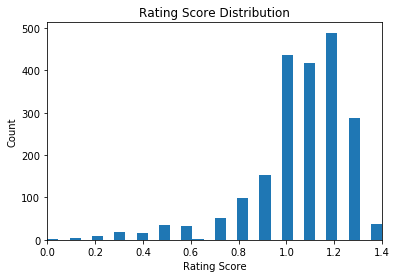

In [45]:
plt.hist(x = archive.rating, bins = 30)
plt.xlim(0,1.4)
plt.xlabel('Rating Score');
plt.ylabel('Count');
plt.title('Rating Score Distribution');
plt.show()

#### Most people rates the dog above 1.0. Nearly 500 people rates dog at 1.2.

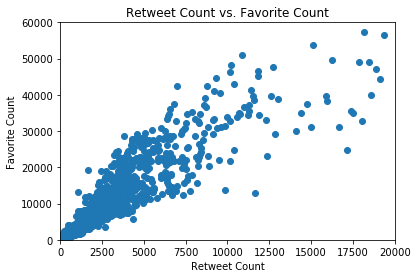

In [51]:
plt.scatter(x = archive.retweet_count, y = archive.favorite_count)
plt.xlim(0, 20000)
plt.ylim(0, 60000)
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');
plt.title('Retweet Count vs. Favorite Count');
plt.show()

#### The retweet count and favorite count show linear relationship.